# Montecarlo calculation for Lennard Jones potential

## Lennard Jones potential
$V(r)=4(\frac{1}{r^{12}}-\frac{1}{r^6})$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

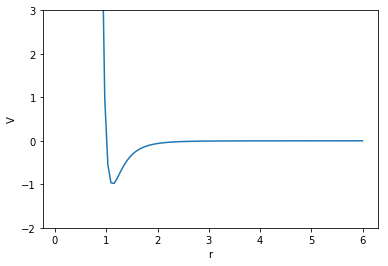

In [3]:
x=np.linspace(0,6, 100)[1:]
y=4*(1/x**12-1/x**6)

plt.plot(x,y)
plt.xlabel('r')
plt.ylabel('V')
plt.ylim(-2, 3)
plt.show()

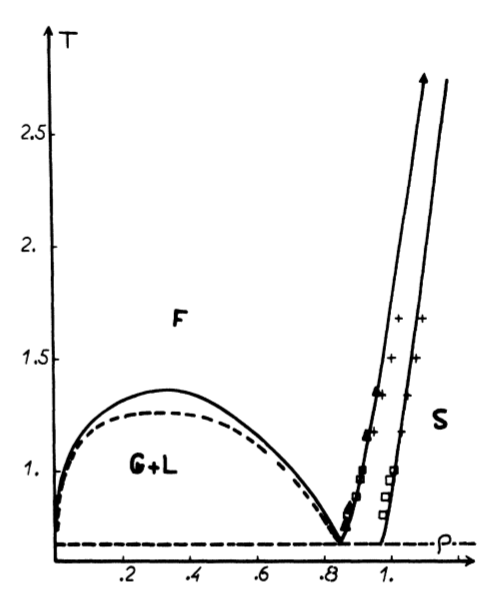

In [4]:
from IPython.display import Image
Image("phasediag.png")

## Utilities

In [94]:
dt = np.dtype([('BETA', np.float64), ('MCTIME', np.float64), ('VIRIAL1', np.float64), ('DELTA', np.float64),
               ('ENERGY', np.float64), ('N1', np.int32), ('L', np.float64), ('ACCEPTANCE', np.float64),
               ('ENERGYSQUARE', np.float64), ('TEMPERATURE', np.float64), ('DENSITY', np.float64),
               ('PRESSURE', np.float64),('CV', np.float64), ('ENERGYERR', np.float64), ('CVERR', np.float64),
               ('N', np.int32), ('THERMTIME', np.int32), ('THBIN', np.int32), ('BTIME', np.int32),
               ('VOLUME', np.float64), ('PRERR', np.float64), ('ENERGYTAIL', np.float64), ('VIRTAIL', np.float64),
               ('CUTOFF', np.float64), ('U', np.float64), ('TOTENERGY', np.float64), ('DELTAIN', np.float64),
               ('FILENAME', np.unicode_, 32)])
print(dt.fields.keys())

dict_keys(['CUTOFF', 'ENERGY', 'DENSITY', 'FILENAME', 'CVERR', 'VIRTAIL', 'PRERR', 'VOLUME', 'ENERGYTAIL', 'N', 'DELTAIN', 'THERMTIME', 'ENERGYSQUARE', 'ACCEPTANCE', 'DELTA', 'BETA', 'VIRIAL1', 'BTIME', 'U', 'N1', 'L', 'CV', 'TEMPERATURE', 'MCTIME', 'TOTENERGY', 'THBIN', 'PRESSURE', 'ENERGYERR'])


In [95]:
import re
import glob

# Read commented lines of the format '# NAME value' and return a structured array
def get_data(file):
    d = np.zeros([], dtype=dt)
    with open(file) as f:
        for line in f:
            try:
                m = re.match("# (\S+) ([-+]?\d+.\d+e[+-]?\d+)", line)
                d[m.group(1)]=float(m.group(2))
            except:
                try:
                    m = re.match("# (\S+) ([-+]?\d+.\d+)", line)
                    d[m.group(1)]=float(m.group(2))
                except:
                    try:
                        m = re.match("# (\S+) (\d+)", line)
                        d[m.group(1)]=int(m.group(2))
                    except: pass
    return d    

## Read data

In [97]:
file = './data/first/test1.out'
d=get_data(file)
arr=np.genfromtxt(file, usemask=True, delimiter='\t')
indmax=int(2*d['THERMTIME']/d['THBIN'])
energyth, virth, rhokth = np.transpose(arr[:indmax])
energybin, ensqbin, virbin =np.transpose(arr[indmax:])
d['ENERGY'] = np.mean(energybin)
d['VIRIAL1'] = np.mean(virbin)
d['ENERGYSQUARE'] = np.mean(ensqbin)
d['TEMPERATURE']=1/d['BETA']
d['VOLUME']=d['L']**3
d['N']=d['N1']**3
d['DENSITY'] = (d['N1']/d['L'])**3
d['CUTOFF']=d['L']/2
d['ENERGYTAIL']=(8*np.pi/3)*d['DENSITY']*(d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
d['VIRTAIL']=(16*np.pi/3)*d['DENSITY']*(2*d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
d['PRESSURE']=(d['TEMPERATURE']+d['VIRIAL1']+d['VIRTAIL'])*d['DENSITY']
d['U']=d['ENERGY']+d['ENERGYTAIL']
d['TOTENERGY']=d['U']+1.5*d['TEMPERATURE']
d['CV']=d['BETA']**2*(d['ENERGYSQUARE']-d['ENERGY']**2)
d['FILENAME']=file
for name in d.dtype.names: print(name, d[name])

BETA 0.5
MCTIME 3600000.0
VIRIAL1 0.34692738320942224
DELTA 0.09
ENERGY -3.036074330555556
N1 5
L 6.3
ACCEPTANCE 0.486922
ENERGYSQUARE 9.22788906388889
TEMPERATURE 2.0
DENSITY 0.4999060176686784
PRESSURE 1.03936882576541
CV 0.0025354308076308563
ENERGYERR 0.0
CVERR 0.0
N 125
THERMTIME 7500
THBIN 50
BTIME 1000
VOLUME 250.04699999999997
PRERR 0.0
ENERGYTAIL -0.13394518286929105
VIRTAIL -0.26779892900011537
CUTOFF 3.15
U -3.170019513424847
TOTENERGY -0.170019513424847
DELTAIN 0.09
FILENAME ./data/first/test1.out


## Equilibration time

( 0.5,  3600000.,  0.34692738,  0.09, -3.03607433, 5,  6.3,  0.486922,  9.22788906,  2.,  0.49990602,  1.03936883,  0.00253543,  0.,  0., 125, 7500, 50, 1000,  250.047,  0., -0.13394518, -0.26779893,  3.15, -3.17001951, -0.17001951,  0.09)


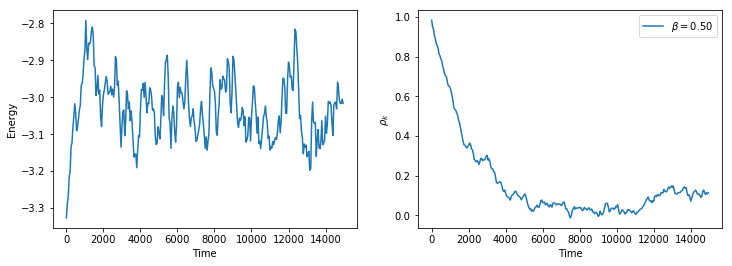

In [8]:
f, axarr = plt.subplots(1,2,figsize=(12,4))

#for file in glob.glob('./data/*.out'):
axarr[0].plot(d['THBIN']*np.arange(len(rhokth)),energyth, label = r'$\beta=$%.2f' % d['BETA'])
axarr[1].plot(d['THBIN']*np.arange(len(rhokth)),rhokth, label = r'$\beta=$%.2f' % d['BETA'])

axarr[0].set_xlabel('Time')
axarr[0].set_ylabel('Energy')
axarr[1].set_xlabel('Time')
axarr[1].set_ylabel(r'$\rho_k$')
print(d)
    
handles, labels = axarr[1].get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
axarr[1].legend(handles, labels)
plt.show()

## Error bars

### Block technique for sample averages
Block technique: we divide the simulation (total number of steps $N_{steps}$) into $k$ blocks of length $t_B$ ($N_{steps}=k \cdot t_B$). We compute the average quantity over each bin $x_{B_i}$. The sample average of $\{x_{B_i}\}$ is $\bar{x}$, so, if the binned quantities are independent variables, the following is an estimator of the variance of $\bar{x}$

\begin{equation}
s^2=\frac{1}{k(k-1)}\sum_{i=1}^k (x_{B_j}-\bar{x})^2.
\end{equation}


When the size of the blocks is much larger than correlation time, $s^2$ approaches the constant value $\sigma^2_{\bar{x}}$.

#### Jackknife estimate of error bars for $s^2$
We apply jackknife technique to calculate the error bars for $s^2$, under the assumption that the bins are large enough to be independent: the unbiased jackknife estimator is obtained as
\begin{equation}
\theta_i^J=\frac{k\bar{x^2}-x_i^2}{k(k-2)}-\frac{(k\bar{x}-x_i)^2}{k(k-1)(k-2)}
\end{equation}

with average

\begin{equation}
\bar{\theta^J}=\frac{1}{k}\sum_i \theta_i^J =\frac{1}{k-1}(\bar{x^2}-\bar{x}^2)=s^2.
\end{equation}

The error according to jackknife technique is given by
\begin{equation}
\delta \theta^2 ={\frac{k-1}{k}\sum_i (\theta_i^J-\bar{\theta^J})^2}
\end{equation}

### Block technique and jackknife for specific heat
For each bin $B_i$ we computed the average of $E$ (we call it $g_i$) and of $E^2$ (we call it $f_i$). The specific heat is proportional to $\langle E^2 \rangle-(\langle E \rangle)^2$ so it can be estimated from
\begin{equation}
C=\bar{E^2}-\bar{E}^2=\bar{f}-\left(\bar{g}\right)^2=\frac{1}{k}\sum_{i=1}^k f_i-\left(\frac{1}{k}\sum_{i=1}^k g_i\right)^2
\end{equation}

We define the unbiased version of the Jackknife estimator
\begin{equation}
C_i^j=\frac{k\bar{f}-f_i}{k-1}+\frac{k\bar{g^2}-g_i^2}{k(k-1)(k-2)}-\frac{(k\bar{g}-g_i)^2}{k(k-2)}.
\end{equation}
It has the property that
\begin{equation}
\frac{1}{k}\sum_{i=1}^k C_i^j =\bar{C^j}=C
\end{equation}

This means that we have been able to write our estimator as the sample average of the $C_i^j$, which are independent variables if the bins are large enough. The variance of $C$ can be estimated using Jackknife technique

\begin{equation}
\delta C =\sqrt{\frac{1}{k-1}\sum_{i=1}^k (C_i^J-C)^2}
\end{equation}

We plot this value for different size of the bins until we reach convergence (size much larger than correlation time).

In [77]:
def binjk(arra, binning):
    binnum=int(len(arra)/binning)
    red_arr = np.reshape(arra, (binning, binnum), order='F').mean(axis=0)
    jk= (np.sum(red_arr**2)-red_arr**2)/binnum/(binnum-2)-(np.sum(red_arr)-red_arr)**2/binnum/(binnum-1)/(binnum-2)
    return np.mean(jk), np.sqrt(np.var(jk)*(binnum-1))

def bincvjk(ens, en, binning):
    binnum=int(len(ens)/binning)
    red_en = np.reshape(en, (binning, binnum), order='F').mean(axis=0)
    red_ens = np.reshape(ens, (binning, binnum), order='F').mean(axis=0)
    cvjk = (np.sum(red_ens)-red_ens)/(binnum-1)+(np.sum(red_en**2)-red_en**2)/(binnum*(binnum-1)*(binnum-2))\
    -(np.sum(red_en)-red_en)**2/(binnum*(binnum-2))
    return d['BETA']**4*np.var(cvjk)*(binnum-1)

npbintec=np.vectorize(binjk, signature='(n),()->(),()')
npbincvjk=np.vectorize(bincvjk, signature='(n),(n),()->()')

In [125]:
bins = np.array([i for i in range(1,70) if int(d['MCTIME']/d['BTIME'])%i==0])

resen=npbintec(energybin, bins)
respr=npbintec(virbin, bins)
reses=npbintec(ensqbin, bins)
rescv=npbincvjk(ensqbin, energybin, bins)

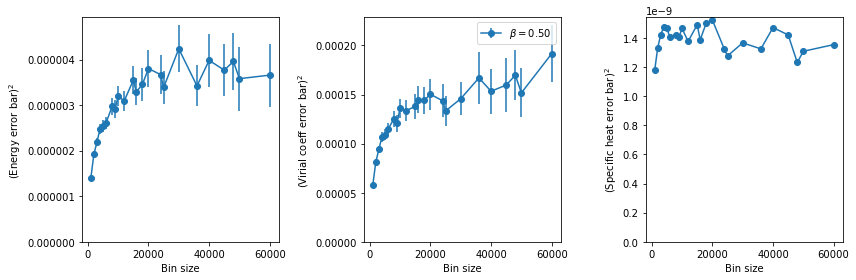

In [126]:
f, axarr = plt.subplots(1,3,figsize=(12,4))

#for file in glob.glob('./data/*.out'):
axarr[0].errorbar(bins*d['BTIME'], resen[0], marker='o', yerr=resen[1], label = r'$\beta=$%.2f' % d['BETA'])
axarr[1].errorbar(bins*d['BTIME'], respr[0], marker='o', yerr=respr[1], label = r'$\beta=$%.2f' % d['BETA'])
axarr[2].plot(bins*d['BTIME'], rescv, marker='o', label = r'$\beta=$%.2f' % d['BETA'])

axarr[0].set_xlabel('Bin size')
axarr[0].set_ylabel(r'(Energy error bar$)^2$')
axarr[1].set_xlabel('Bin size')
axarr[1].set_ylabel(r'(Virial coeff error bar$)^2$')
axarr[2].set_xlabel('Bin size')
axarr[2].set_ylabel(r'(Specific heat error bar$)^2$')


for ax in axarr: ax.set_ylim(ymin=0)

handles, labels = axarr[1].get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
axarr[1].legend(handles, labels)
plt.tight_layout()
plt.show()

# Analysis

In [116]:
nictab=np.loadtxt('./nicolastab.dat', unpack=True)
N1=5

def deltaf(el):
    cb=-0.1
    cL=0.05
    delta0=-0.11
    return delta0+cb*el[1]+cL*el[0]
deltaf((4.70518, 0.166))
    
#for counter, el in enumerate(zip(nictab[0]**(-1/3)*N1, 1/nictab[1])):
#    delta = deltaf(el)
#    file = open('./data/nicolas_test/test%04d.in' % counter,'w') 
#    file.write("N1      5\nL       %.8f\nDELTAIN 0.09\nBETA    %.8f\nMCTIME  3600000\
#    \nBTIME   10000\nTHBIN   50\n" % el)
#    file.close()

0.10865900000000003

0.34998772570296766 2.994011976047904 -2.0437046400600765 1.0019114884420084 0.0021856924835118377 0.0007649655413903792
0.34998772570296766 2.5 -2.1288046400600766 0.829013434543436 0.0019578851368613932 0.0006852357662377626
0.34998772570296766 1.968503937007874 -2.2469046400600763 0.6429961323398413 0.004464872025304298 0.0015626504056910542
0.34998772570296766 1.7006802721088436 -2.3103546400600763 0.5492611862461179 0.002508598727089603 0.0008779787631954497
0.34998772570296766 1.4492753623188408 -2.3993046400600764 0.4612725956370321 0.005692752938796371 0.0019923936540382275
0.34998772570296766 1.2004801920768309 -2.5341546400600765 0.37419735750517874 0.010329208284149814 0.0036150961156818464


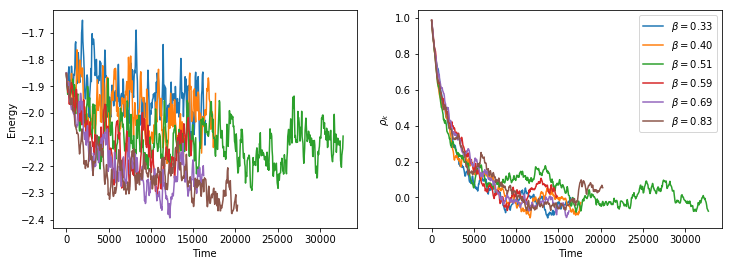

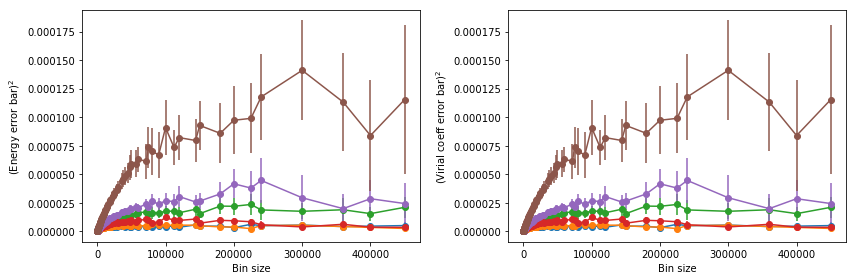

In [98]:
fth, axarrth = plt.subplots(1,2,figsize=(12,4))
feb, axarreb = plt.subplots(1,2,figsize=(12,4))

dataset=np.empty(0, dtype=dt)

for file in glob.glob('./data/run1/*.out'):
    d=get_data(file)
    arr=np.genfromtxt(file, usemask=True, delimiter='\t')
    indmax=int(2*d['THERMTIME']/d['THBIN'])
    energyth, virth, rhokth = np.transpose(arr[:indmax])
    energybin, virbin =np.transpose(arr[indmax:])[:-1]
    d['TEMPERATURE']=1/d['BETA']
    d['VOLUME']=d['L']**3
    d['N']=d['N1']**3
    d['DENSITY'] = (d['N1']/d['L'])**3
    d['CUTOFF']=d['L']/2
    d['ENERGYTAIL']=(8*np.pi/3)*d['DENSITY']*(d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
    d['VIRTAIL']=(16*np.pi/3)*d['DENSITY']*(2*d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
    d['PRESSURE']=(d['TEMPERATURE']+d['VIRIAL1']+d['VIRTAIL'])*d['DENSITY']
    d['U']=d['ENERGY']+d['ENERGYTAIL']
    d['TOTENERGY']=d['U']+1.5*d['TEMPERATURE']
    d['CV']=d['BETA']**2*(d['ENERGYSQUARE']-d['ENERGY']**2)
    bins = np.array([i for i in range(1,10000) if int(d['MCTIME']/d['BTIME'])%i==0])
    resen=npbintec(energybin, bins)
    respr=npbintec(energybin, bins)
    #d['ENERGYERR']=np.sqrt(np.mean(resen[0][-8:])*d['BTIME']/d['MCTIME'])
    #d['CVERR']=np.mean(resen[1][-8:])*d['BTIME']/d['MCTIME']
    #d['PRERR']=np.sqrt(np.mean(respr[0][-8:])*d['BTIME']/d['MCTIME'])*d['DENSITY']
    axarrth[0].plot(d['THBIN']*np.arange(len(rhokth)),energyth, label = r'$\beta=$%.2f' % d['BETA'])
    axarrth[1].plot(d['THBIN']*np.arange(len(rhokth)),rhokth, label = r'$\beta=$%.2f' % d['BETA'])
    axarreb[0].errorbar(bins*d['BTIME'], resen[0], marker='o', yerr=resen[1], label = r'$\beta=$%.2f' % d['BETA'])
    axarreb[1].errorbar(bins*d['BTIME'], respr[0], marker='o', yerr=respr[1], label = r'$\beta=$%.2f' % d['BETA'])
    dataset=np.append(dataset, d)
    #print(d['DENSITY'], d['TEMPERATURE'], d['U'], d['PRESSURE'], d['ENERGYERR'], d['PRERR'])
   
axarrth[0].set_xlabel('Time')
axarrth[0].set_ylabel('Energy')
axarrth[1].set_xlabel('Time')
axarrth[1].set_ylabel(r'$\rho_k$')
handlesth, labelsth = axarrth[1].get_legend_handles_labels()
labelsth, handlesth = zip(*sorted(zip(labelsth, handlesth), key=lambda t: t[0]))
axarrth[1].legend(handlesth, labelsth)    
    
axarreb[0].set_xlabel('Bin size')
axarreb[0].set_ylabel(r'(Energy error bar$)^2$')
axarreb[1].set_xlabel('Bin size')
axarreb[1].set_ylabel(r'(Virial coeff error bar$)^2$')   
handleseb, labelseb = axarreb[1].get_legend_handles_labels()
labelseb, handleseb = zip(*sorted(zip(labelseb, handleseb), key=lambda t: t[0]))
axarr[1].legend(handleseb, labelseb)
    
plt.tight_layout()
plt.show()